# Análise Inicial: Algoritmo referente ao Paper de Diabetes

## Predição de Diabetes com Machine Learning e Deep Learning

**Dataset:** Dataset_of_Diabetes.csv (1000 registros, 14 atributos)  
**Objetivo:** Classificar pacientes em 3 categorias: Normal (N), Pré-diabético (P), Diabético (Y)  

---

### 📊 Algoritmos Testados:

**Algoritmos Tradicionais:**
1. K-Nearest Neighbors (K-NN)
2. Naive Bayes
3. Support Vector Machine (SVM)
4. Decision Tree
5. Random Forest
6. Logistic Regression

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import mlflow
from mlflow.models.signature import infer_signature

In [14]:
OUTPUT_DIR = "reports"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Diretório de saída configurado: {os.path.abspath(OUTPUT_DIR)}")

Diretório de saída configurado: /home/jovyan/reports


In [15]:
DB_HOST = os.getenv('DB_HOST', 'db')
DB_PORT = os.getenv('DB_PORT', '5432') 
DB_USER = os.getenv('DB_USER', 'user')
DB_PASS = os.getenv('DB_PASS', 'password')
DB_NAME = os.getenv('DB_NAME', 'diabetes_db')

db_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"


try:
    engine = create_engine(db_url)
    raw_conn = engine.raw_connection()
    
    try:
        df = pd.read_sql("SELECT * FROM diabetes_tb", raw_conn)
        df.columns = [c.upper() for c in df.columns]
        
        print(f"SUCESSO! Conexão estabelecida via {DB_HOST}.")
        print(f"Dados carregados: {df.shape[0]} linhas.")
        display(df.head())
    finally:
        raw_conn.close()
        
except Exception as e:
    print(f"Erro de conexão: {e}")

SUCESSO! Conexão estabelecida via db.
Dados carregados: 1000 linhas.


/tmp/ipykernel_520/2639957197.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM diabetes_tb", raw_conn)


,ID,NO_PATION,GENDER,AGE,UREA,CR,HBA1C,CHOL,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


### Análise exploratória inicial - Distribuição dos dados antes da limpeza

Gerando gráficos de distribuição antes da limpeza...


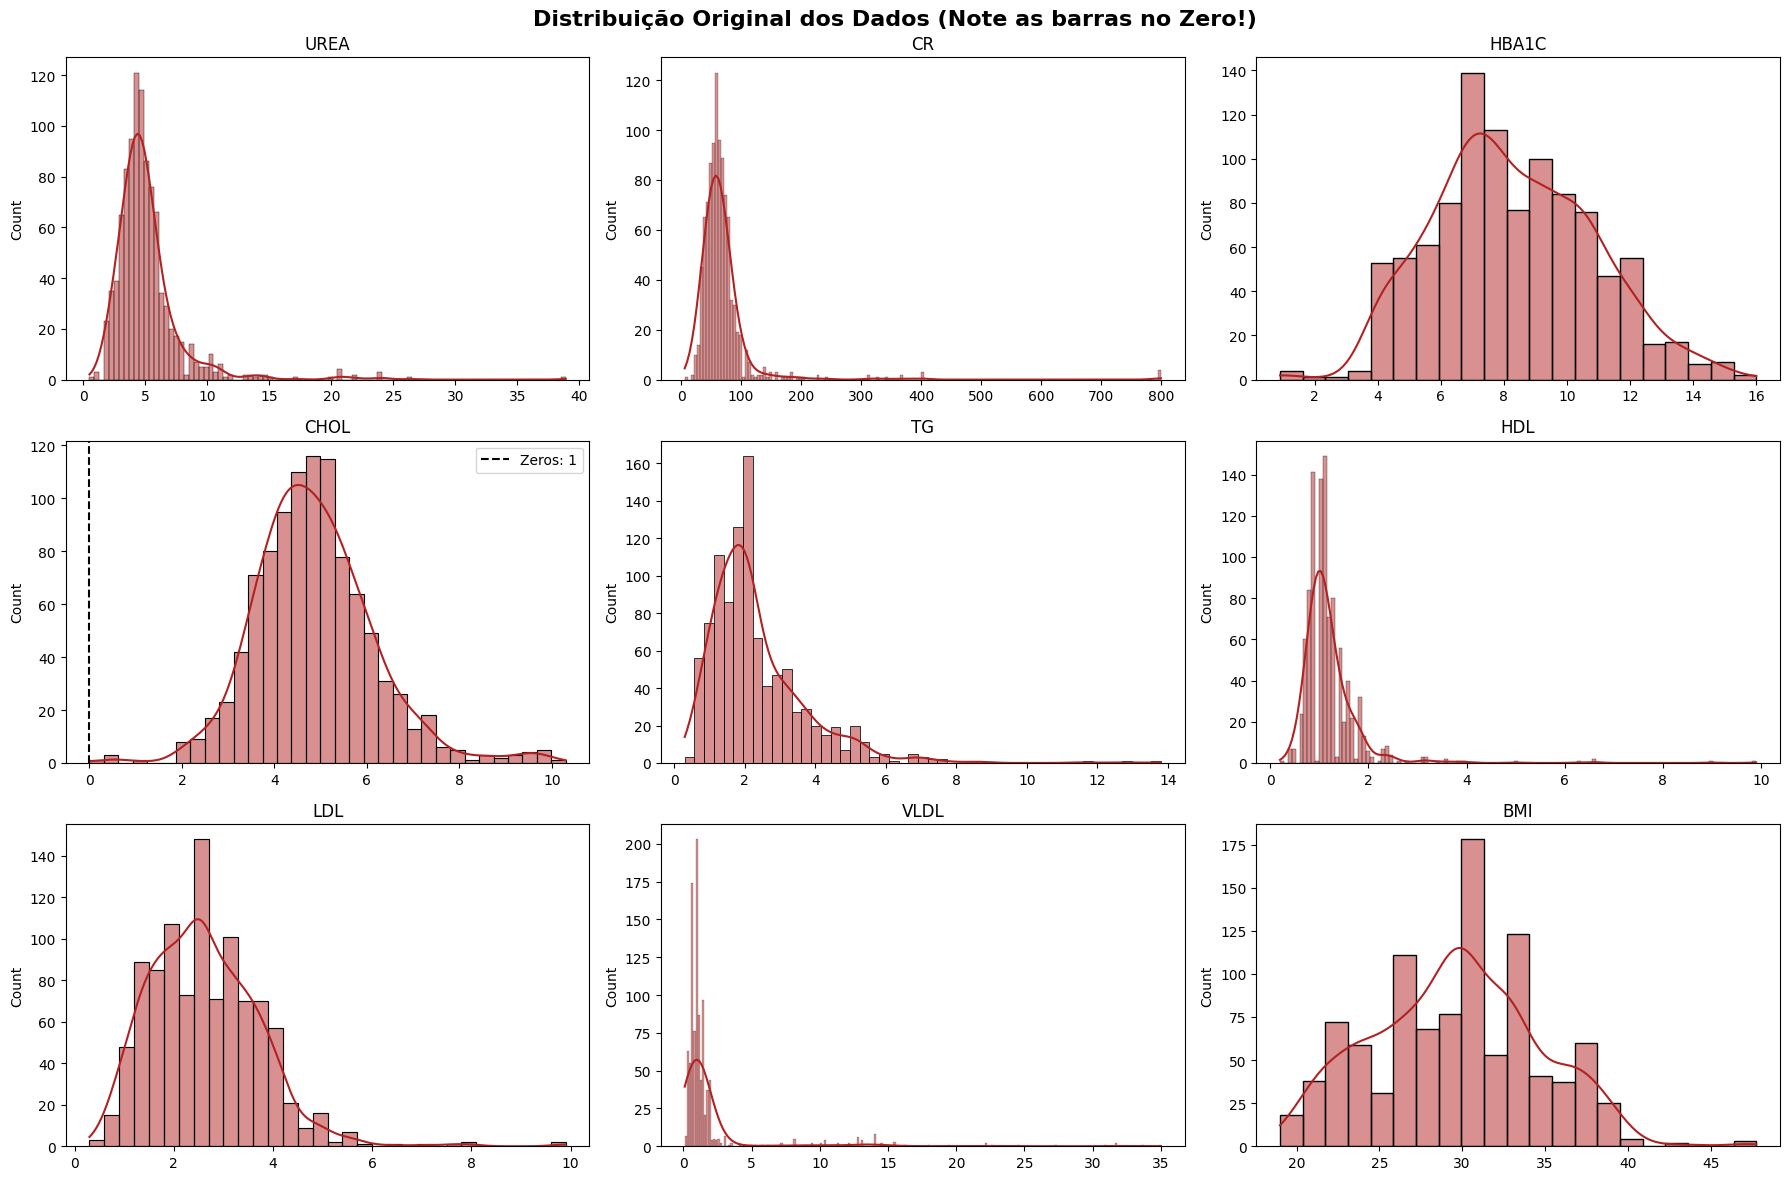

In [16]:
cols_analise = ['UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

print("Gerando gráficos de distribuição antes da limpeza...")

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Distribuição Original dos Dados (Note as barras no Zero!)', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, col in enumerate(cols_analise):
    if col in df.columns:
        ax = axes[i]
        
        sns.histplot(df[col], kde=True, color='firebrick', ax=ax)
        
        zeros = (df[col] == 0).sum()
        if zeros > 0:
            ax.axvline(0, color='black', linestyle='--', label=f'Zeros: {zeros}')
            ax.legend()
            
        ax.set_title(f'{col}')
        ax.set_xlabel('')

plt.tight_layout()


arquivo_antes = f'{OUTPUT_DIR}/distribuicao_antes_limpeza.png'
plt.savefig(arquivo_antes)
plt.show()

### Limpeza dos Dados

In [17]:
df_clean = df.copy()

# 1. Remove colunas de ID se existirem
cols_drop = ['ID', 'NO_PATION']
df_clean = df_clean.drop(columns=[c for c in cols_drop if c in df_clean.columns], errors='ignore')

/tmp/ipykernel_520/3938172589.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CLASS', data=df_clean, palette='viridis')


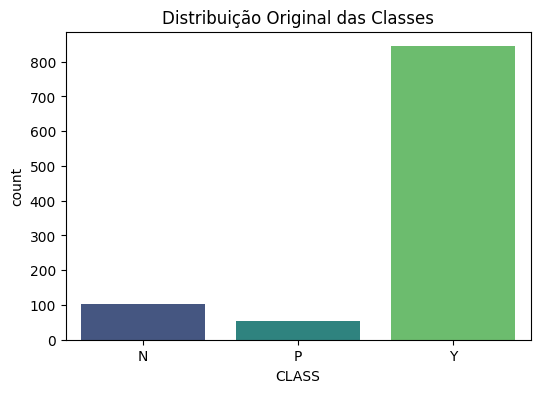

In [18]:
# 2. Limpa a coluna alvo (CLASS) e transforma em números
if 'CLASS' in df_clean.columns:
    df_clean['CLASS'] = df_clean['CLASS'].astype(str).str.strip()

    # N = 0 (Saudável), Y e P = 1 (Risco)
    df_clean['TARGET'] = df_clean['CLASS'].map({'N': 0, 'Y': 1, 'P': 1})
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='CLASS', data=df_clean, palette='viridis')
    plt.title('Distribuição Original das Classes')
    plt.savefig(f'{OUTPUT_DIR}/matrizes_confusao.png')
    plt.show()
    
    df_clean = df_clean.drop(columns=['CLASS'])

/tmp/ipykernel_520/1732117679.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENDER', data=df_clean, palette='pastel')


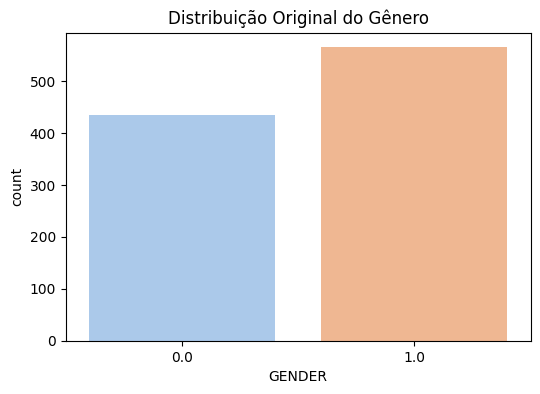

In [19]:
# 3. Limpa Gênero (Se existir, transforma F/M em 0/1)
if 'GENDER' in df_clean.columns:
    df_clean['GENDER'] = df_clean['GENDER'].astype(str).str.strip().map({'F': 0, 'M': 1})

    plt.figure(figsize=(6, 4))
    sns.countplot(x='GENDER', data=df_clean, palette='pastel')
    plt.title('Distribuição Original do Gênero')
    plt.savefig(f'{OUTPUT_DIR}/matrizes_confusao.png')
    plt.show()

In [20]:
# Tratamento de Zeros (Exames como Glicose e BMI não podem ser zero e se forem, são dados faltantes)
cols_exames = ['UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
cols_presentes = [c for c in cols_exames if c in df_clean.columns]

# Substitui 0 por NaN (Vazio)
df_clean[cols_presentes] = df_clean[cols_presentes].replace(0, np.nan)

df_clean = df_clean.fillna(df_clean.mean())
df_clean = df_clean.dropna()

## Divisão de Treino e Teste

In [21]:
# Separa X (Dados) e y (Alvo)
X = df_clean.drop('TARGET', axis=1)
y = df_clean['TARGET']

# Divisão 80% Treino / 20% Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização (Deixar tudo na mesma escala - Importante pro KNN e SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dados divididos: {X_train.shape[0]} treino, {X_test.shape[0]} teste.")

Dados divididos: 800 treino, 200 teste.


In [22]:
modelos = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

resultados = {}
metricas_detalhadas = []

for nome, modelo in modelos.items():
    # Treina
    modelo.fit(X_train_scaled, y_train)
    
    # Preve
    y_pred = modelo.predict(X_test_scaled)
    
    # Calcula Acurácia
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    resultados[nome] = {'accuracy': acc, 'matrix': cm}
    
    print(f"   -> {nome}: {acc:.2%} de acurácia.")

   -> KNN: 97.50% de acurácia.
   -> Naive Bayes: 93.50% de acurácia.
   -> SVM: 96.50% de acurácia.
   -> Decision Tree: 99.50% de acurácia.
   -> Random Forest: 100.00% de acurácia.
   -> Logistic Regression: 96.50% de acurácia.


## Passando as informações para o MLFlow

In [23]:
print("Configurando ambiente blindado...")

if os.getenv('DB_HOST'):
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"
    mlflow.set_tracking_uri("http://mlflow:5000")
else:
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://127.0.0.1:9000"
    mlflow.set_tracking_uri("http://127.0.0.1:5000")

os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

mlflow.set_experiment("Projeto_ML_Diabetes")

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nProcessando: {nome}...")
    try:
        with mlflow.start_run(run_name=nome) as run:
            
            # 1. Treina
            modelo.fit(X_train_scaled, y_train)
            
            # 2. Avalia
            y_pred = modelo.predict(X_test_scaled)
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            
            # 3. Assinatura (Schema)
            signature = infer_signature(X_train_scaled, y_pred)
            
            # 4. Logs
            mlflow.log_param("algoritmo", nome)
            mlflow.log_metric("acuracia", acc)
            
            # 5. Salva Modelo (Onde costuma dar erro)
            mlflow.sklearn.log_model(
                sk_model=modelo, 
                artifact_path=f"modelo_{nome.lower().replace(' ', '_')}",
                signature=signature,
                input_example=X_train_scaled[:5]
            )
            
            resultados[nome] = {'accuracy': acc, 'matrix': cm}
            print(f"Sucesso! Acurácia: {acc:.2%}")
            
    except Exception as e:
        print(f"FALHA no modelo {nome}: {str(e)}")
        traceback.print_exc()

print("\nFim do processamento! Verifique o MLFlow.")

2025/12/02 21:49:20 INFO mlflow.tracking.fluent: Experiment with name 'Projeto_ML_Diabetes' does not exist. Creating a new experiment.


Configurando ambiente blindado...

Processando: KNN...


2025/12/02 21:49:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/12/02 21:49:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

Sucesso! Acurácia: 97.50%
🏃 View run KNN at: http://mlflow:5000/#/experiments/2/runs/a79c519b4f784219abcea437ffd77d56
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Processando: Naive Bayes...


2025/12/02 21:49:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpcyia0bv4/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 21:49:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Sucesso! Acurácia: 93.50%
🏃 View run Naive Bayes at: http://mlflow:5000/#/experiments/2/runs/aaaa4f581dc14e24b5f572bcb01f6b1e
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Processando: SVM...


2025/12/02 21:49:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyrqh5m0c/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 21:49:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Sucesso! Acurácia: 96.50%
🏃 View run SVM at: http://mlflow:5000/#/experiments/2/runs/e471a33a749b4c29bf95f26c0403aa46
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Processando: Decision Tree...


2025/12/02 21:49:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpbh1rtlry/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 21:49:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Sucesso! Acurácia: 99.50%
🏃 View run Decision Tree at: http://mlflow:5000/#/experiments/2/runs/b6b11e0b762f4f7eb6112853f9b7418f
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Processando: Random Forest...


2025/12/02 21:49:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2_jzb9b9/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 21:49:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Sucesso! Acurácia: 100.00%
🏃 View run Random Forest at: http://mlflow:5000/#/experiments/2/runs/037cf461e512444c936fa93beb2ca67f
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Processando: Logistic Regression...


2025/12/02 21:49:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpf2bw1vlc/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 


Sucesso! Acurácia: 96.50%
🏃 View run Logistic Regression at: http://mlflow:5000/#/experiments/2/runs/3b35934b48624cbe886331f52be503d4
🧪 View experiment at: http://mlflow:5000/#/experiments/2

Fim do processamento! Verifique o MLFlow.


## Representação visual 

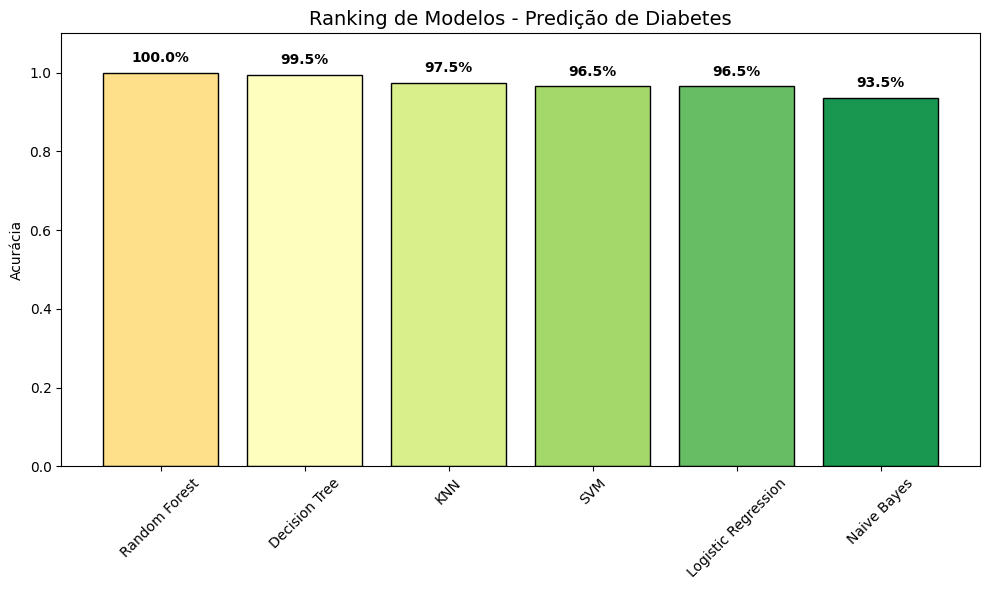

In [24]:
# 1. Gráfico de Comparação de Acurácia
plt.figure(figsize=(10, 6))

# Ordena do melhor para o pior
ranking = dict(sorted(resultados.items(), key=lambda x: x[1]['accuracy'], reverse=True))

nomes = list(ranking.keys())
valores = [ranking[k]['accuracy'] for k in nomes]
cores = plt.cm.RdYlGn(np.linspace(0.4, 0.9, len(nomes)))

barras = plt.bar(nomes, valores, color=cores, edgecolor='black')

plt.title('Ranking de Modelos - Predição de Diabetes', fontsize=14)
plt.ylabel('Acurácia')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)

for barra in barras:
    height = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., height + 0.02,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/ranking_modelos.png')
plt.show()

arquivo_resumo = f'{OUTPUT_DIR}/resumo_executivo.txt'
with open(arquivo_resumo, 'w', encoding='utf-8') as f:
    f.write("RESUMO DOS RESULTADOS\n")
    f.write("="*30 + "\n\n")
    for nome, dados in ranking.items():
        f.write(f"{nome}: {dados['accuracy']:.4f}\n")
        

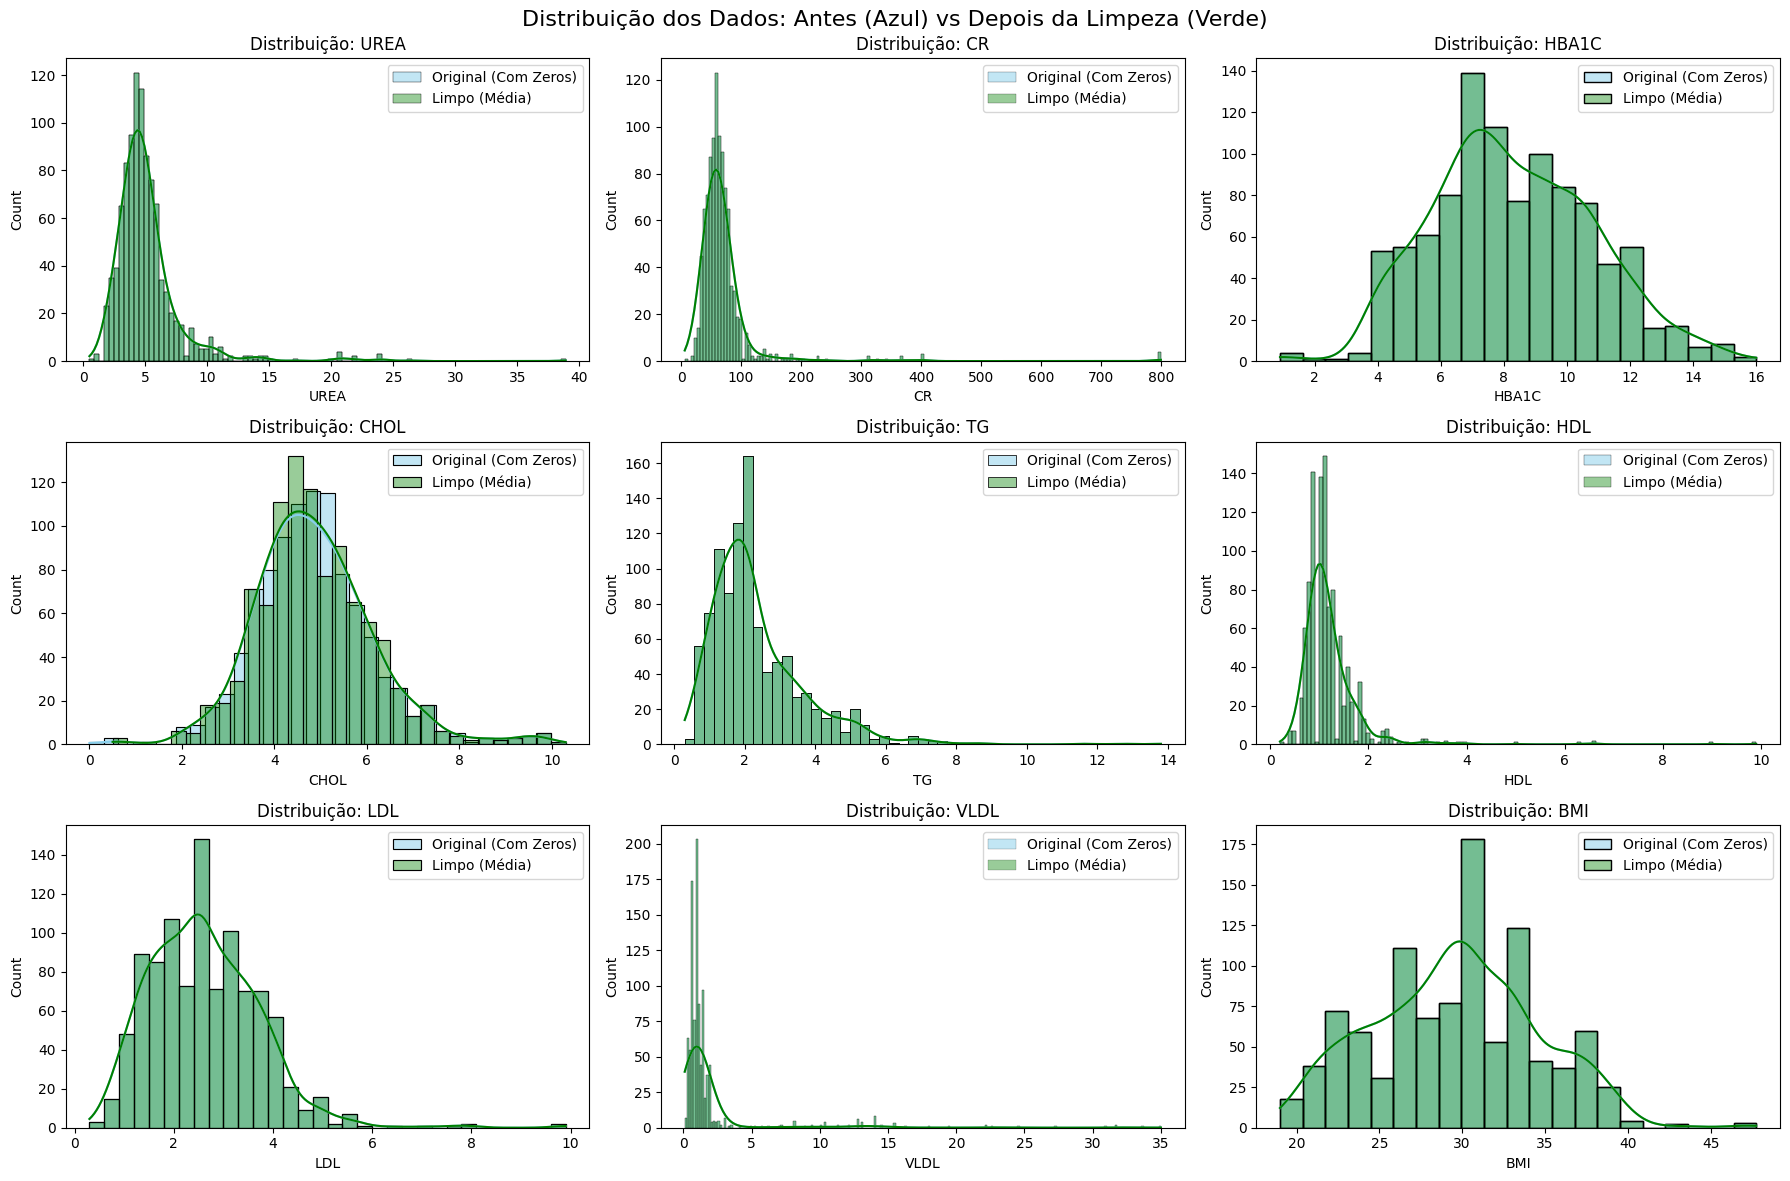

In [25]:
# Vamos pegar as colunas numéricas importantes
cols_exames = ['UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Distribuição dos Dados: Antes (Azul) vs Depois da Limpeza (Verde)', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(cols_exames):
    if col in df.columns and col in df_clean.columns:
        ax = axes[i]
        
        # 1. Plot do "Antes" (Dados Originais com Zeros)
        sns.histplot(df[col], color='skyblue', label='Original (Com Zeros)', kde=True, ax=ax, alpha=0.5)
        
        # 2. Plot do "Depois" (Limpos e Imputados)
        sns.histplot(df_clean[col], color='green', label='Limpo (Média)', kde=True, ax=ax, alpha=0.4)
        
        ax.set_title(f'Distribuição: {col}')
        ax.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comparacao_limpeza.png')
plt.show()

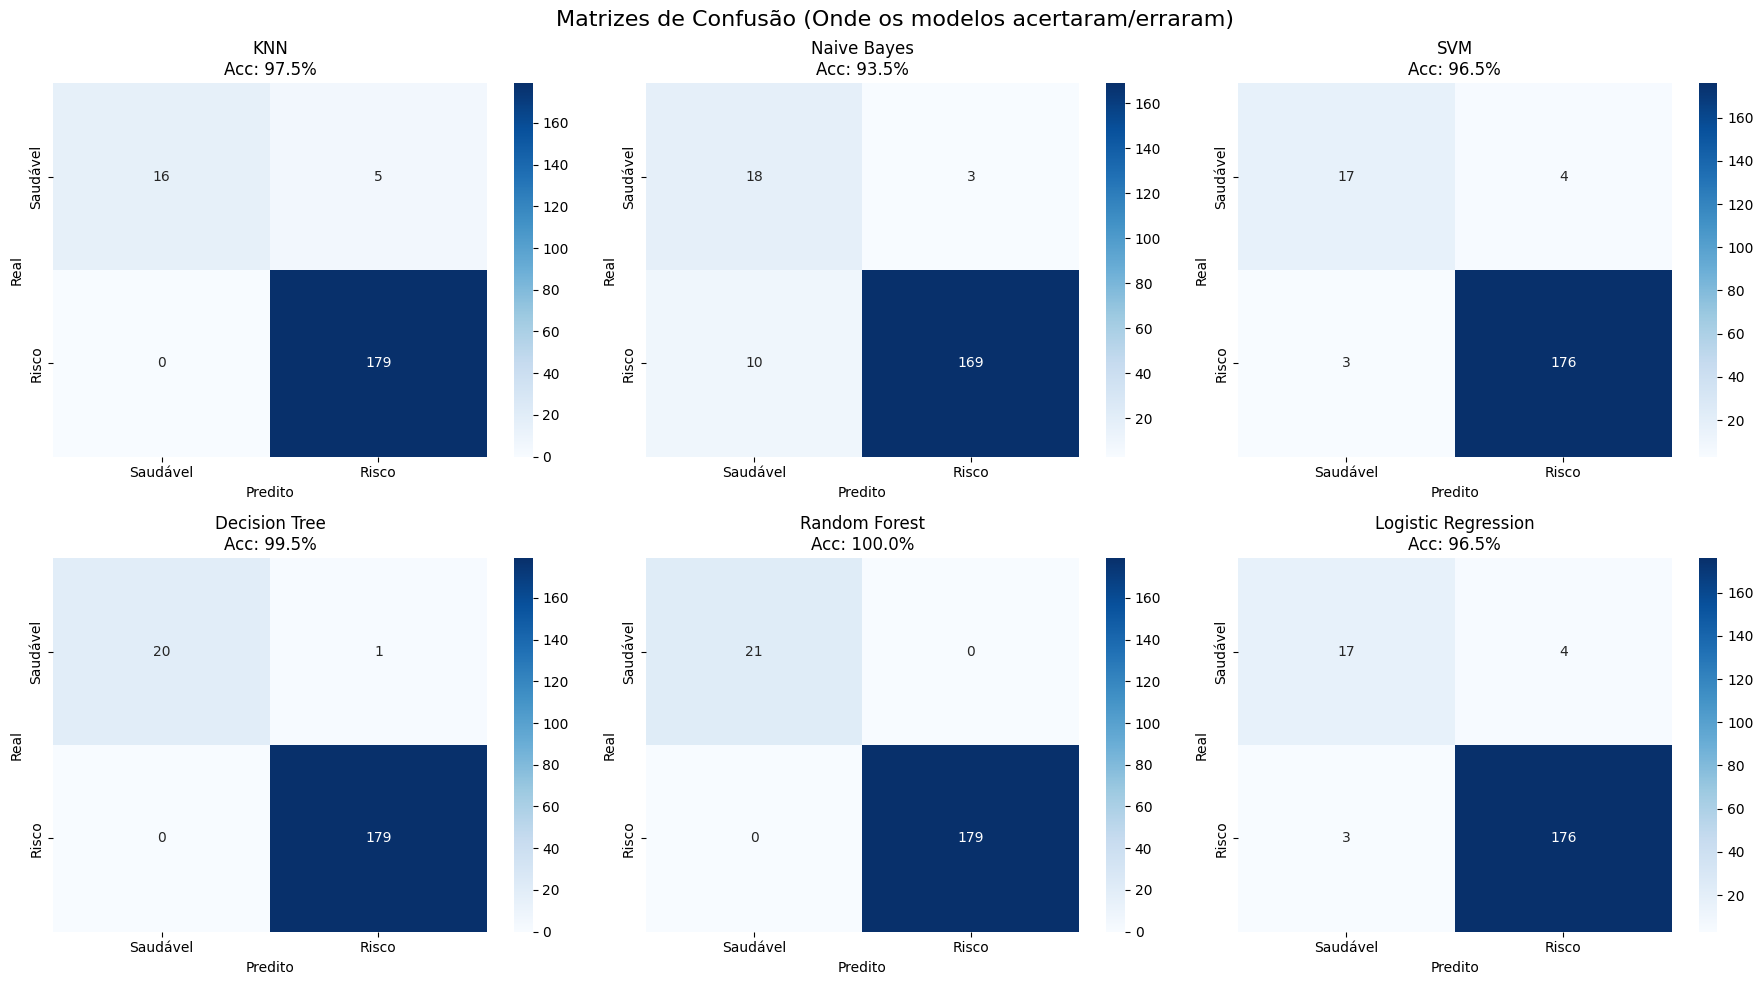

In [26]:
# Plota as matrizes de confusão
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Matrizes de Confusão (Onde os modelos acertaram/erraram)', fontsize=16)

for idx, (nome, dados) in enumerate(resultados.items()):
    ax = axes[idx // 3, idx % 3]
    sns.heatmap(dados['matrix'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{nome}\nAcc: {dados["accuracy"]:.1%}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    ax.set_xticklabels(['Saudável', 'Risco'])
    ax.set_yticklabels(['Saudável', 'Risco'])       

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/matrizes_confusao.png')
plt.show()

In [27]:
caminho_arquivo = f'{OUTPUT_DIR}/resumo_final.txt'

with open(caminho_arquivo, 'w', encoding='utf-8') as f:
    f.write("="*50 + "\n")
    f.write("RESUMO EXECUTIVO - PROJETO DIABETES\n")
    f.write("="*50 + "\n\n")
    
    f.write(f"Total de Modelos Avaliados: {len(resultados)}\n")
    f.write("-" * 30 + "\n")
    f.write("RANKING DE PERFORMANCE (Acurácia):\n")
    f.write("-" * 30 + "\n\n")
    
    ranking = sorted(resultados.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    for i, (nome, dados) in enumerate(ranking, 1):
        acc = dados['accuracy']
        medalha = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        
        f.write(f"{medalha} {nome}: {acc:.2%} de acurácia\n")
    
    f.write("\n" + "="*50 + "\n")
    f.write("CONCLUSÃO AUTOMÁTICA:\n")
    melhor_modelo = ranking[0][0]
    melhor_acc = ranking[0][1]['accuracy']
    
    if melhor_acc == 1.0:
        f.write(f"O modelo '{melhor_modelo}' atingiu performance perfeita (100%).\n")
        f.write("Isso indica forte correlação linear dos atributos clínicos (ex: HbA1c) com o alvo.\n")
    else:
        f.write(f"O modelo recomendado é o '{melhor_modelo}' com {melhor_acc:.2%} de assertividade.\n")